# Исследование сервиса аренды самокатов

__Цель исследования:__

1. Подсчитать выручку с подписанных и неподписанных пользователей по месяцам
2. Проверка различных гипотез с целью повышения дальнейшей прибыли

__Ход исследования:__
* Загрузить данные из трёх файлов
* Проанализировать качество данных
* Построить несколько показательных графиков, проанализировать полученные данные
* Собрать нужную сводную таблицу, добавить столбец с выручкой и проверить некоторые гипотезы

__Описание данных:__
* В основных данных есть информация о пользователях, их поездках и подписках.
* Данные о пользователях хранятся в файле `'/datasets/users_go.csv'`
* Данные о поездках пользователей хранятся в файле `'/datasets/rides_go.csv'`
* Данные о подписказ пользователей хранятся в файле `'/datasets/subscriptions_go.csv'`

#### Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


__В данных нет пропусков, столбцы названы корректно;__

#### Шаг 2. Предобработка данных

<b>Приведём столбец date к нужному типу данных:</b>

In [6]:
rides['date'] = rides['date'].astype('datetime64[M]')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


<b>Добавим столбец, указывающий на месяц поездки:</b>

In [7]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-01,1
2,1,754.159807,6.232113,2021-04-01,4
3,1,2694.783254,18.511000,2021-08-01,8
4,1,4028.687306,26.265803,2021-08-01,8


In [8]:
print("Период данных:", rides['date'].min(), "-", rides['date'].max())

Период данных: 2021-01-01 00:00:00 - 2021-12-01 00:00:00


<b>Обработаем дубликаты:</b>

<b>Users:</b>

In [9]:
users.duplicated().sum()

31

In [10]:
users = users.drop_duplicates().reset_index(drop=True)

In [11]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

<b>Rides:</b>

In [12]:
rides.duplicated().sum()

0

In [13]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

<b>Subscriptions:</b>

In [14]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<b>=> Всё подготовленно к следующему этапу</b>

На этапе предобработки данных мы выявили, что пропуски в данных отсутствуют, удалили явные дубликаты из таблицы users, а также привели столбец date в таблице rides к нужному типу данных (датированный). Там же мы добавили столбец, указывающий на месяц поездки

#### Шаг 3. Исследовательский анализ данных

In [15]:
cities = users['city'].value_counts()

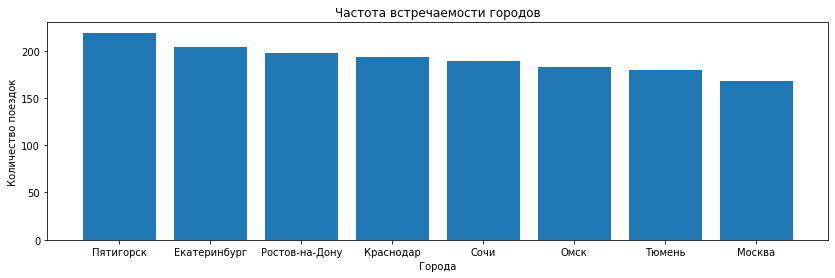

In [16]:
plt.figure(figsize = (14,4))
plt.bar(cities.index, cities.values)
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Количество поездок')
plt.show()

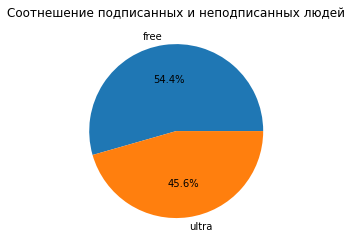

In [17]:
plt.pie(users['subscription_type'].value_counts(), labels=['free', 'ultra'], autopct='%1.1f%%')
plt.title('Соотнешение подписанных и неподписанных людей')
plt.show()

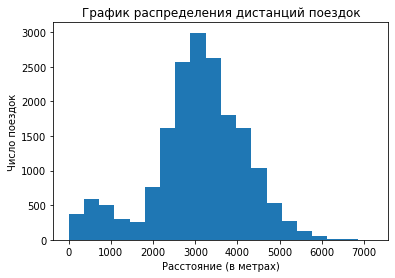

In [18]:
def dist_plot(data):
    plt.hist(data['distance'], bins=20)
    plt.xlabel('Расстояние (в метрах)')
    plt.ylabel('Число поездок')
    plt.title('График распределения дистанций поездок')
    plt.show()

dist_plot(rides)

__Кажется, что данные распределены нормально;__

In [19]:
rides.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


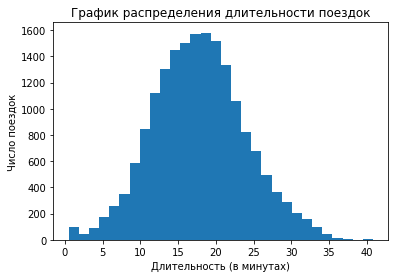

In [20]:
def dur_plot(data):
    plt.hist(data['duration'], bins=30)
    plt.xlabel('Длительность (в минутах)')
    plt.ylabel('Число поездок')
    plt.title('График распределения длительности поездок')
    plt.show()
    
dur_plot(rides)

__Аналогично;__

#### Шаг 4. Объединение данных

In [21]:
user_rides = pd.merge(users, rides, on='user_id')
merged_data = pd.merge(user_rides, subs)
merged_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-01,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-01,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-01,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-01,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-01,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-01,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-01,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-01,11,8,50,0


In [22]:
print(users.shape)
print(rides.shape)
print(user_rides.shape)
print(merged_data.shape)

(1534, 5)
(18068, 5)
(18068, 9)
(18068, 12)


In [23]:
ultra_subs = merged_data.query('subscription_type == "ultra"')
ultra_subs

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-01,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-01,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-01,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-01,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-01,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-01,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-01,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-01,10,6,0,199


In [24]:
free_subs = merged_data.query('subscription_type == "free"')
free_subs

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-01,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-01,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-01,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-01,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-01,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-01,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-01,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-01,11,8,50,0


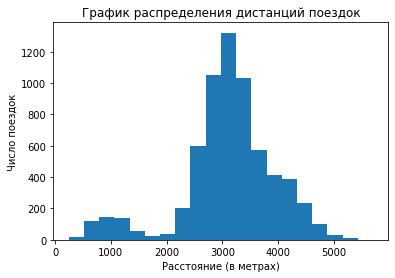

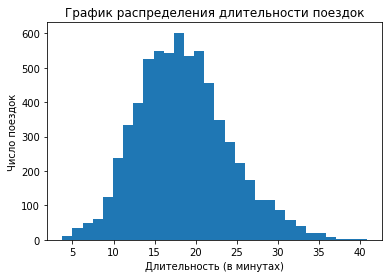

In [25]:
dist_plot(ultra_subs)
dur_plot(ultra_subs)

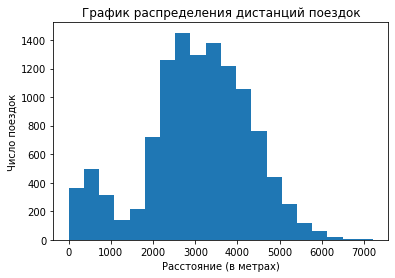

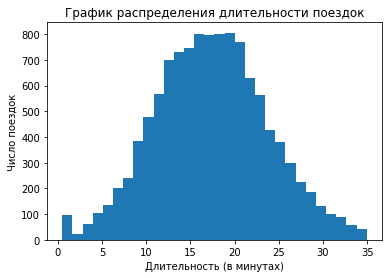

In [26]:
dist_plot(free_subs)
dur_plot(free_subs)

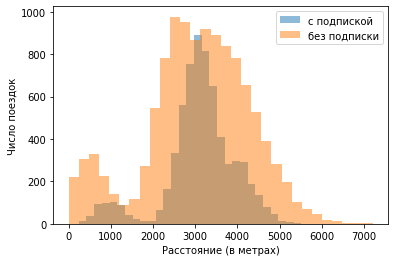

In [27]:
plt.hist(ultra_subs['distance'], bins=30, alpha=0.5, label='с подпиской')
plt.hist(free_subs['distance'], bins=30, alpha=0.5, label='без подписки')
plt.xlabel('Расстояние (в метрах)')
plt.ylabel('Число поездок')
plt.legend()

plt.show()

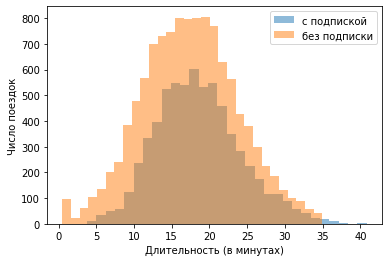

In [28]:
plt.hist(ultra_subs['duration'], bins=30, alpha=0.5, label='с подпиской')
plt.hist(free_subs['duration'], bins=30, alpha=0.5, label='без подписки')
plt.xlabel('Длительность (в минутах)')
plt.ylabel('Число поездок')
plt.legend()

plt.show()

__Кажется, что все данные распределены нормально;__

__Данные объеденены, стоит начать добавлять нужные столбцы__

#### Шаг 5. Подсчёт выручки

In [29]:
merged_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-01,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-01,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-01,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-01,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-01,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-01,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-01,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-01,11,8,50,0


In [31]:
# создаем новый столбец с округленной продолжительностью поездки
merged_data['duration_round'] = np.ceil(merged_data['duration'])

# группируем данные по user_id и месяцу
grouped_trips = merged_data.groupby(['user_id', 'month']) \
                            .agg({'distance': 'sum',
                                  'user_id': 'count',
                                  'duration_round': 'sum',
                                  'subscription_fee': 'first',
                                  'minute_price': 'first',
                                  'start_ride_price': 'first'})

grouped_trips.columns = ['total_distance', 'trip_count', 'total_time', 'sub_fee', 'min_price', 'start_price']
grouped_trips = grouped_trips.reset_index()

grouped_trips = pd.merge(grouped_trips, users[['user_id', 'subscription_type']], on='user_id', how='left')

grouped_trips.columns = ['user_id', 'month', 'total_distance',
                         'trip_count', 'total_time', 'sub_fee',
                         'min_price', 'start_price', 'sub_type']
grouped_trips

,user_id,month,total_distance,trip_count,total_time,sub_fee,min_price,start_price,sub_type
0,1,1,7027.511294,2,42.0,199,6,0,ultra
1,1,4,754.159807,1,7.0,199,6,0,ultra
2,1,8,6723.470560,2,46.0,199,6,0,ultra
3,1,10,5809.911100,2,32.0,199,6,0,ultra
4,1,11,7003.499363,3,56.0,199,6,0,ultra
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,0,8,50,free
11327,1534,8,7622.453034,2,48.0,0,8,50,free
11328,1534,9,4928.173852,1,23.0,0,8,50,free
11329,1534,11,13350.015305,4,78.0,0,8,50,free


In [32]:
def my_func(row):
    return row['total_time'] * row['min_price'] + row['trip_count'] * row['start_price'] + row['sub_fee']

grouped_trips['cost'] = grouped_trips.apply(my_func, axis=1)
grouped_trips

,user_id,month,total_distance,trip_count,total_time,sub_fee,min_price,start_price,sub_type,cost
0,1,1,7027.511294,2,42.0,199,6,0,ultra,451.0
1,1,4,754.159807,1,7.0,199,6,0,ultra,241.0
2,1,8,6723.470560,2,46.0,199,6,0,ultra,475.0
3,1,10,5809.911100,2,32.0,199,6,0,ultra,391.0
4,1,11,7003.499363,3,56.0,199,6,0,ultra,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,0,8,50,free,308.0
11327,1534,8,7622.453034,2,48.0,0,8,50,free,484.0
11328,1534,9,4928.173852,1,23.0,0,8,50,free,234.0
11329,1534,11,13350.015305,4,78.0,0,8,50,free,824.0


__Добавлен столбец с подсчётом выручки ползьователей по месяцам;__

#### Шаг 6. Проверка гипотез

__6.1 Тратят ли пользователи с подпиской больше времени на поездки?__

H0: Средние значения длительности поездок пользователей с подпиской и без подписки равны
<br>H1: Среднее значение длительности поездок пользователей с подпиской больше, чем ползователей без подписки

In [33]:
# разделение данных на два DataFrame: подписчики и не подписчики
subscribers = merged_data[merged_data['subscription_type'] == 'ultra']
non_subscribers = merged_data[merged_data['subscription_type'] == 'free']

# проведение t-теста
stat, p = ttest_ind(subscribers['duration'], non_subscribers['duration'], alternative='greater')

# вывод результатов теста
print("sub mean:", subscribers['duration'].mean())
print("non_sub mean:", non_subscribers['duration'].mean())
print("p-value:", p)
if p < 0.05:
    print("Отвергаем нулевую гипотезу. Среднее значение длительности поездок пользователей с подпиской не меньше, чем у ползователей без подписки.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Средние значения длительности поездок пользователей с подпиской и без подписки равны.")

sub mean: 18.54198516280583
non_sub mean: 17.39090929866399
p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу. Среднее значение длительности поездок пользователей с подпиской не меньше, чем у ползователей без подписки.


<b>6.2 Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?</b>

H0: Расстояние, которое проезжают пользователи с подпиской равно 3130 метров
<br>H1: Расстояние, которое проехжают пользователи с подпиской больше 3130 метров

In [34]:
# проведение одновыборочного t-теста

stat, p = ttest_1samp(subscribers['distance'], 3130, alternative='greater')

# вывод результатов теста
print("sub mean:", subscribers['distance'].mean())
print("p-value:", p)
if p < 0.05:
    print("Отвергаем нулевую гипотезу. Расстояние, которое проехжают пользователи с подпиской больше 3130 метров")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Расстояние, которое проезжают пользователи с подпиской равно 3130 метров")

sub mean: 3115.4453880370247
p-value: 0.9195368847849785
Не удалось отвергнуть нулевую гипотезу. Расстояние, которое проезжают пользователи с подпиской равно 3130 метров


__6.3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?__

H0: Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки
<br>H1: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

In [35]:
# проведение t-теста
subscribers = grouped_trips[grouped_trips['sub_type'] == 'ultra']
non_subscribers = grouped_trips[grouped_trips['sub_type'] == 'free']

stat, p = ttest_ind(subscribers['cost'], non_subscribers['cost'], alternative='greater')

# вывод результатов
print("sub mean:", subscribers['cost'].mean())
print("non_sub mean:", non_subscribers['cost'].mean())
print("p-value:", p)
if p < 0.05:
    print("Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам выше выручки от пользователей без подписки.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.")

sub mean: 362.7921906022502
non_sub mean: 328.6413651073845
p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам выше выручки от пользователей без подписки.


__6.4__

Выборки в задании являются зависимыми, так как для каждого пользователя в файле известны значения количества обращений до и после обновления серверов.

для проверки этой гипотезы нам бы понадобился метод **scipy.stats.ttest_rel()**

Гипотезы звучали бы так:

H0: Количество обращений в техподдержку до обновления серверов равно количеству обращений в техподдержку после обновления серверов
<br>H1: Количество обращений в техподдержку после обновления серверов меньше количества обращений в техподдержку до обновления серверов

__Общий вывод__

В этом проекте мы провели следующие исследования:
* Обработали данные о некоторых пользователях из нескольких городов, а также об их поездках при использовании сервиса аренды самокатов GoFast
* Для удобства собрали **все данные в одну таблицу**
* Посчитали выручку за каждого пользователя (разделили их на пользователей с тарифом **ultra** и без подписки)
* Графически вывели количество поездок по городам, продолжительность и дальность поездок пользователей с подпиской и без, **нашли интересные закономерности** (например, **количество поездок в Пятигорске самое большое, когда в Москве - самое низкое**, а количество подписанных пользователей составило **45.6%**)
* Выявили, что **в среднем** пользователи проезжают ~3км, а поездка длится около 18 минут
* **Проверили различные гипотезы относительно длительности, дальности а также выручки** и получили следующие выводы:
    1. Средние значения длительности поездок пользователей **с подпиской и без подписки равны**
    2. Расстояние, которое проехжают пользователи **с подпиской** больше 3130 метров
    3. Помесячная **выручка от пользователей с подпиской по месяцам выше выручки от пользователей без подписки.**